# Evalute model performance

We can calculate the distance between labeled coordinates and the coordinates extracted from the model predicted segmentation masks.


In [1]:
!pip install albumentations==1.3.0
!git clone https://github.com/kevin-allen/unetTracker
!pip install -r unetTracker/requirements.txt
!pip install -e unetTracker

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.5/123.5 kB 3.9 MB/s eta 0:00:00
  Attempting uninstall: albumentations
    Found existing installation: albumentations 1.3.1
    Uninstalling albumentations-1.3.1:
      Successfully uninstalled albumentations-1.3.1
Cloning into 'unetTracker'...
remote: Enumerating objects: 825, done.
remote: Counting objects: 100% (204/204), done.
remote: Compressing objects: 100% (162/162), done.
remote: Total 825 (delta 110), reused 100 (delta 41), pack-reused 621
Receiving objects: 100% (825/825), 122.30 MiB | 39.73 MiB/s, done.
Resolving deltas: 100% (500/500), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.2/9.2 MB 21.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.6/511.6 kB 37.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.0/66.0 kB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 379.0/379.0 kB 46.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.9/58.9 kB 9.9

Obtaining file:///content/unetTracker
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Installing backend dependencies ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for unetTracker (pyproject.toml) ... done
  Created wheel for unetTracker: filename=unetTracker-0.0.1-0.editable-py3-none-any.whl size=15897 sha256=1b28133b7efa03ef2b6641bbfdea9b760060d9a2607d7a37b8bdbd0081bdcd82
  Stored in directory: /tmp/pip-ephem-wheel-cache-f7c70vk5/wheels/62/9b/5a/0cb547490a9187d698861d98e1e803c5e64f31a9d899a8e84c
Successfully built unetTracker


In [2]:
import torch
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import albumentations as A


from tqdm import tqdm
from torch import optim
import torch.nn as nn
from datetime import datetime
import albumentations as A
import cv2
import os
import pickle


from unetTracker.trackingProject import TrackingProject
from unetTracker.dataset import UNetDataset
from unetTracker.unet import Unet
from unetTracker.coordinatesFromSegmentationMask import CoordinatesFromSegmentationMask

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import os
fn = "/content/drive/My Drive/teaching_thesis_taq/Data_science_neuroscience/master_neuroscience_2023/unetTracker/finger_tracker/config.yalm"
if os.path.exists(fn):
  print("We can access the unet-tracker project directory.")
else:
  raise IOError("Problem accessing the unet-tracker project directory.")

We can access the unet-tracker project directory.


In [6]:
project = TrackingProject(name="finger_tracker",
                          root_folder = "/content/drive/My Drive/teaching_thesis_taq/Data_science_neuroscience/master_neuroscience_2023/unetTracker/")

Project directory: /content/drive/My Drive/teaching_thesis_taq/Data_science_neuroscience/master_neuroscience_2023/unetTracker/finger_tracker
Getting configuration from config file. Values from config file will be used.
Loading /content/drive/My Drive/teaching_thesis_taq/Data_science_neuroscience/master_neuroscience_2023/unetTracker/finger_tracker/config.yalm
{'augmentation_HorizontalFlipProb': 0.0, 'augmentation_RandomBrightnessContrastProb': 0.2, 'augmentation_RandomSizedCropProb': 1.0, 'augmentation_RotateProb': 0.3, 'image_extension': '.png', 'image_size': [270, 480], 'labeling_ImageEnlargeFactor': 2.0, 'name': 'finger_tracker', 'normalization_values': {'means': [0.40835028886795044, 0.4549056589603424, 0.51627117395401], 'stds': [0.23996737599372864, 0.251758873462677, 0.26929107308387756]}, 'object_colors': [(0.0, 0.0, 255.0), (255.0, 0.0, 0.0), (255.0, 255.0, 0.0), (240.0, 255.0, 255.0)], 'objects': ['f1', 'f2', 'f3', 'f4'], 'target_radius': 6, 'unet_features': [64, 128, 256, 512

In [7]:
TRAIN_IMAGE_DIR = os.path.join(project.dataset_dir,"train_images")
TRAIN_MASK_DIR =  os.path.join(project.dataset_dir,"train_masks")
TRAIN_COORDINATE_DIR = os.path.join(project.dataset_dir,"train_coordinates")
VAL_IMAGE_DIR = os.path.join(project.dataset_dir,"val_images")
VAL_MASK_DIR =  os.path.join(project.dataset_dir,"val_masks")
VAL_COORDINATE_DIR = os.path.join(project.dataset_dir,"val_coordinates")



DEVICE = (torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu"))
BATCH_SIZE = 2
NUM_WORKERS = 2
PIN_MEMORY=False

In [8]:
fileName = os.path.join(project.augmentation_dir,"valTransform")
print("Loading valTransform from", fileName)
valTransform=pickle.load(open(fileName, "rb" ))
print(valTransform)

Loading valTransform from /content/drive/My Drive/teaching_thesis_taq/Data_science_neuroscience/master_neuroscience_2023/unetTracker/finger_tracker/augmentation/valTransform
Compose([
  Normalize(always_apply=False, p=1.0, mean=[0.40835028886795044, 0.4549056589603424, 0.51627117395401], std=[0.23996737599372864, 0.251758873462677, 0.26929107308387756], max_pixel_value=255.0),
], p=1.0, bbox_params=None, keypoint_params=None, additional_targets={})


In [9]:
valDataset = UNetDataset(VAL_IMAGE_DIR, VAL_MASK_DIR,VAL_COORDINATE_DIR, transform=valTransform)
trainDataset = UNetDataset(TRAIN_IMAGE_DIR, TRAIN_MASK_DIR,TRAIN_COORDINATE_DIR, transform=valTransform) # use same transform as for val
dataset = UNetDataset(VAL_IMAGE_DIR, VAL_MASK_DIR,VAL_COORDINATE_DIR, transform=None)

valLoader = DataLoader(valDataset,shuffle=False,batch_size=BATCH_SIZE, num_workers=NUM_WORKERS,pin_memory = PIN_MEMORY)
trainLoader = DataLoader(trainDataset,shuffle=False,batch_size=BATCH_SIZE, num_workers=NUM_WORKERS,pin_memory = PIN_MEMORY)

In [10]:
model = Unet(in_channels=3, out_channels=len(project.object_list)).to(DEVICE)
project.load_model(model)
a = model.eval()

Let's get an item from the validation dataset

In [11]:
len(trainDataset)

168

In [12]:
imageIndex=1
image,mask,coord = valDataset[imageIndex]
imageOri,_,_ =dataset[imageIndex]

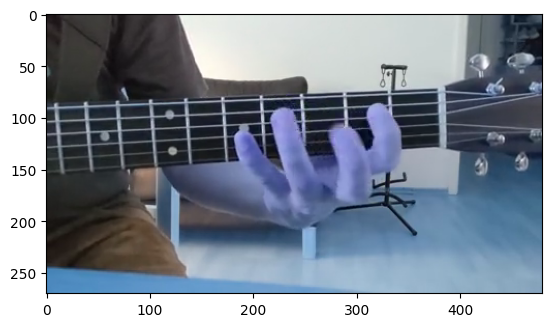

In [13]:
imageOri =imageOri.permute(1,2,0).numpy()
imageOri = imageOri.astype(np.uint8)
plt.imshow(imageOri)

In [14]:
cDetector = CoordinatesFromSegmentationMask()

In [15]:
from unetTracker.utils import check_accuracy

In [16]:
check_accuracy(model,valLoader,DEVICE)

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Number of positive pixels predicted: 6225.0
Number of positive pixels in masks: 6431.0
Percentage of positive pixels predicted: 0.075
Percentage of positive pixels in masks: 0.078
Accuracy: 99.945
Dice score: 0.625
Mask pixels detected (True positives): 62.727%
False positives: 35.197%
Mean distance: 5.409372713809956


In [17]:
check_accuracy(model,trainLoader,DEVICE)

Number of positive pixels predicted: 71925.0
Number of positive pixels in masks: 70500.0
Percentage of positive pixels predicted: 0.083
Percentage of positive pixels in masks: 0.081
Accuracy: 99.963
Dice score: 0.770
Mask pixels detected (True positives): 77.996%
False positives: 23.550%
Mean distance: 2.655850499349743
